在进行K-Means Clustering算法之前，先对数据进行初步的补全，在这里使用均值补全。

In [1]:
import numpy as np
import pandas as pd


def initial_imputation(chart):
    means = [np.mean(chart.loc[:, column]) for column in chart.columns]
    
    for column in range(len(chart.columns)):
        chart.iloc[:, column] = chart.iloc[:, column].fillna(means[column])
    
    return chart


chart = pd.DataFrame(
    {'a': [1, 3, 2, 5, 4],
     'b': [1, 2, None,2, None], 
     'c': [None, 2, 1, 4, 6], 
     'd': [2, 4, 5, None, 3]}
)
initial_imputation(chart)

,a,b,c,d
0,1,1.000000,3.25,2.0
1,3,2.000000,2.00,4.0
2,2,1.666667,1.00,5.0
3,5,2.000000,4.00,3.5
4,4,1.666667,6.00,3.0


应用K-Means Clustering算法。

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


def k_means_clustering(chart, k=2):
    # 由于K-Means Clustering算法对于极端值很敏感，所以在进行聚类之前先对数据每一列进行标准化。 
    scaler = StandardScaler()
    scaled_chart = scaler.fit_transform(chart)
    
    # 初始化聚类算法，设置簇数和随机状态（任何数都可以）。
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_chart)
    chart.loc[:, 'cluster']= kmeans.labels_
    
    return chart


chart = pd.DataFrame(
    {'a': [1, 3, 2, 5, 4, 3, 2, 5, 4, 3, 2, 5, 4, 3, 2, 5, 4, 3, 2, 5],
     'b': [1, 2, 4, 1, 7, 6, 5, 4, 3, 2, 5, 4, 3, 2, 5, 4, 3, 2, 5, 77],
     'c': [23, 2, 1, 4, 88, 5, 6, 3, 2, 5, 4, 3, 2, 5, 4, 3, 2, 5, 33, 21], 
     'd': [2, 4, 5, 0, 3, 23, 11, 22, 12, 23, 11, 54, 23, 34, 55, 12, 2, 1, 0, 9],
     'e': [2, 4, 5, 33, 3, 1, 2, 3, 4, 2, 1, 7, 7, 7, 7, 7, 7, 7, 7, 3],
     'f': [10, 67, 5, 33, 9, 2, 4, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, None, None]
     }
)
initial_imputation(chart)
k_means_clustering(chart, 3)
chart

,a,b,c,d,e,f,cluster
0,1,1,23,2,2,10.000000,1
1,3,2,2,4,4,67.000000,2
2,2,4,1,5,5,5.000000,1
3,5,1,4,0,33,33.000000,0
4,4,7,88,3,3,9.000000,1
5,3,6,5,23,1,2.000000,1
6,2,5,6,11,2,4.000000,1
7,5,4,3,22,3,5.000000,0
8,4,3,2,12,4,7.000000,0
9,3,2,5,23,2,7.000000,1


由于K-Means Clustering算法中的K是自己给定的，所以需要确定如何设定一个K才是合理的，在这里我们使用R^2来确定K值。R^2=B_k/T，B_k计算的是类间平方和，描述的是每个簇的中心相对于整体中心的距离的平方；T描述的是所有样本相对于整体中心的距离的平方。R^2与K成正比，当K -> +∞时，R^2 -> 1。所以当R^2的增量小于特定数值时，选定对应的K。这个时候我们应该看图说话。

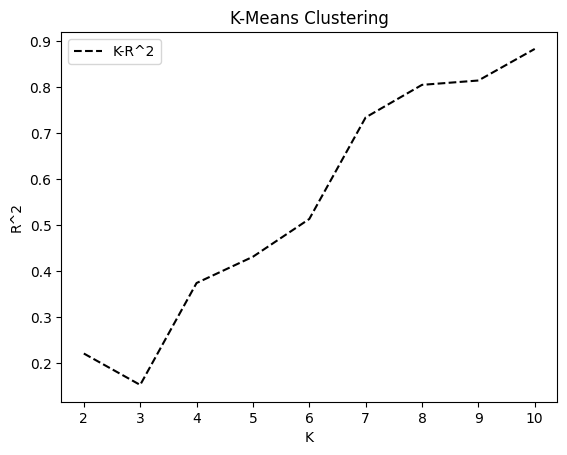

,a,b,c,d,e,f
0,1,1,23,2,2,10.000000
1,3,2,2,4,4,67.000000
2,2,4,1,5,5,5.000000
3,5,1,4,0,33,33.000000
4,4,7,88,3,3,9.000000
5,3,6,5,23,1,2.000000
6,2,5,6,11,2,4.000000
7,5,4,3,22,3,5.000000
8,4,3,2,12,4,7.000000
9,3,2,5,23,2,7.000000


In [12]:
import matplotlib.pyplot as plt

def get_k_based_on_r2(chart):
    k_r2 = {}
    
    # 设定K的范围为[2, 样本数量的1/2]。
    for k in range(2, len(chart.index) // 2 + 1):
        k_means_clustering(chart, k)
        chart_center = [np.mean(chart.loc[:, column]) for column in chart.columns]
        t = 0
        bk = 0
        
        # 计算T。
        for row in chart.index:
            division = chart.loc[row, :] - chart_center
            
            for i in range(len(division)):
                t += division.iloc[i] ** 2
        
        # 计算B_k。
        for cluster in range(k):
            group = chart[chart.loc[:, 'cluster'] == cluster]
            group_center = [np.mean(group.loc[:, column]) for column in chart.columns]
            division = [group_center[i] - chart_center[i] for i in range(len(group_center))]
            
            for i in range(len(division)):
                bk += division[i] ** 2
                    
        r2 = bk / t
        k_r2[k] = r2
        chart.drop(['cluster'], axis=1, inplace=True)
        
    plt.figure()
    plt.plot(k_r2.keys(), k_r2.values(), color='black', linestyle='--', label='K-R^2')
    plt.legend()
    plt.xlabel('K')
    plt.ylabel('R^2')
    plt.title('K-Means Clustering')
    plt.show()
    
    return chart

chart = pd.DataFrame(
    {'a': [1, 3, 2, 5, 4, 3, 2, 5, 4, 3, 2, 5, 4, 3, 2, 5, 4, 3, 2, 5],
     'b': [1, 2, 4, 1, 7, 6, 5, 4, 3, 2, 5, 4, 3, 2, 5, 4, 3, 2, 5, 77],
     'c': [23, 2, 1, 4, 88, 5, 6, 3, 2, 5, 4, 3, 2, 5, 4, 3, 2, 5, 33, 21], 
     'd': [2, 4, 5, 0, 3, 23, 11, 22, 12, 23, 11, 54, 23, 34, 55, 12, 2, 1, 0, 9],
     'e': [2, 4, 5, 33, 3, 1, 2, 3, 4, 2, 1, 7, 7, 7, 7, 7, 7, 7, 7, 3],
     'f': [10, 67, 5, 33, 9, 2, 4, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, None, None]
     }
)
initial_imputation(chart)
get_k_based_on_r2(chart)
chart

根据分类进行补全。

In [ ]:
def kmeans_imputation(chart, k):
    """

    :param chart: 表格。
    :param k: 簇数。
    :return: 经过K-Means_Clustering补全后的数据。
    """
    for cluster in range(k):
        group = chart[chart.loc[:, 'cluster'] == cluster]

        for column in group.columns:
            if column == 'cluster':
                continue

            meanValue = np.mean(group.loc[:, column])
            chart.loc[group.index, column] = group.loc[:, column].fillna(meanValue)

    return chart


综合过程：首先使用initial_imputation对数据进行初步补全，然后使用get_k_based_on_r2得到合适的K，然后使用k_means_clustering得到该K下的分类。然后根据该分类进行补全操作。